In [13]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from transformers import AutoImageProcessor, AutoModelForImageClassification, AdamW
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import numpy as np

num_epochs    = 3
batch_size    = 32
learning_rate = 2e-5
weight_decay  = 0.01
num_folds     = 5
random_seed   = 42
model_name = "trpakov/vit-face-expression"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(random_seed)
np.random.seed(random_seed)



In [14]:
def load_datasets(directory):
    image_paths, labels = [], []
    for lbl in os.listdir(directory):
        lbl_dir = os.path.join(directory, lbl)
        if not os.path.isdir(lbl_dir):
            continue
        for fname in os.listdir(lbl_dir):
            image_paths.append(os.path.join(lbl_dir, fname))
            labels.append(lbl)
    return image_paths, labels

train_dir = "../data/train"
test_dir  = "../data/test"

train_paths, train_labels = load_datasets(train_dir)
test_paths,  test_labels  = load_datasets(test_dir)

le      = LabelEncoder()
y_train = le.fit_transform(train_labels)
label_names = le.classes_

# WeightedRandomSampler
class_counts   = np.bincount(y_train)
class_weights  = 1.0 / class_counts
samples_weight = class_weights[y_train]
base_sampler   = WeightedRandomSampler(
    weights=samples_weight,
    num_samples=len(samples_weight),
    replacement=True
)




In [15]:
#resize + normalize
processor = AutoImageProcessor.from_pretrained(model_name)
img_size   = processor.size["height"]

# transform
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(img_size, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
])
val_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
])
 
class FERDataset(Dataset):
    def __init__(self, paths, labels, processor, transform=None):
        self.paths     = paths
        self.labels    = labels
        self.processor = processor
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        pv = self.processor(images=img, return_tensors="pt")["pixel_values"].squeeze(0)
        return pv, self.labels[idx]



In [18]:
kf   = KFold(n_splits=num_folds, shuffle=True, random_state=random_seed)
fold = 0

for train_idx, val_idx in kf.split(train_paths):
    fold += 1
    print(f"Fold {fold}/{num_folds}")

    tr_paths  = [train_paths[i] for i in train_idx]
    tr_labels = [y_train[i]     for i in train_idx]
    vl_paths  = [train_paths[i] for i in val_idx]
    vl_labels = [y_train[i]     for i in val_idx]

    fold_counts  = np.bincount(tr_labels)
    fold_wts     = 1.0 / fold_counts
    fold_sw      = fold_wts[np.array(tr_labels)]
    fold_sampler = WeightedRandomSampler(
        weights=fold_sw,
        num_samples=len(fold_sw),
        replacement=True
    )

    train_ds = FERDataset(tr_paths, tr_labels, processor, transform=train_transform)
    val_ds   = FERDataset(vl_paths, vl_labels, processor, transform=val_transform)

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        sampler=fold_sampler,
        num_workers=0,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )



Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


In [19]:
    # freeze the body param
    model = AutoModelForImageClassification.from_pretrained(model_name)
    for param in model.vit.parameters():
        param.requires_grad = False
    # dropout
    model.config.classifier_dropout = 0.3
    model.classifier = nn.Sequential(
        nn.Dropout(model.config.classifier_dropout),
        model.classifier
    )
    model.to(device)

    optimizer = AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay
    )

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)



/Users/mo/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [20]:
    for epoch in range(1, num_epochs+1):
        # train
        model.train()
        train_corr = train_tot = 0
        for imgs, lbls in tqdm(train_loader, desc=f"[Fold {fold}] Epoch {epoch} Train"):
            imgs, lbls = imgs.to(device), lbls.to(device)
            outputs    = model(pixel_values=imgs).logits
            loss       = criterion(outputs, lbls)
            loss.backward()

            # gradient cut
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            optimizer.zero_grad()

            preds      = outputs.argmax(dim=1)
            train_corr += (preds == lbls).sum().item()
            train_tot  += lbls.size(0)

        train_acc = train_corr / train_tot

        # val
        model.eval()
        val_corr = val_tot = 0
        val_loss = 0.0
        with torch.no_grad():
            for imgs, lbls in tqdm(val_loader, desc=f"[Fold {fold}] Epoch {epoch} Val"):
                imgs, lbls  = imgs.to(device), lbls.to(device)
                outs        = model(pixel_values=imgs).logits
                loss_v      = criterion(outs, lbls)
                val_loss   += loss_v.item()

                preds_v     = outs.argmax(dim=1)
                val_corr   += (preds_v == lbls).sum().item()
                val_tot    += lbls.size(0)

        val_acc = val_corr / val_tot
        val_loss /= len(val_loader)

        print(f"[Fold {fold}] Epoch {epoch}"
              f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")


    

[Fold 5] Epoch 1 Val: 100%|██████████| 180/180 [03:46<00:00,  1.26s/it]


[Fold 5] Epoch 1Train Acc: 0.7289, Val Acc: 0.9880


[Fold 5] Epoch 2 Val: 100%|██████████| 180/180 [05:39<00:00,  1.88s/it]


[Fold 5] Epoch 2Train Acc: 0.7394, Val Acc: 0.9868


[Fold 5] Epoch 3 Val: 100%|██████████| 180/180 [04:35<00:00,  1.53s/it]

[Fold 5] Epoch 3Train Acc: 0.7523, Val Acc: 0.9866


[Fold 5] Confusion Matrix Eval: 100%|██████████| 180/180 [03:47<00:00,  1.27s/it]


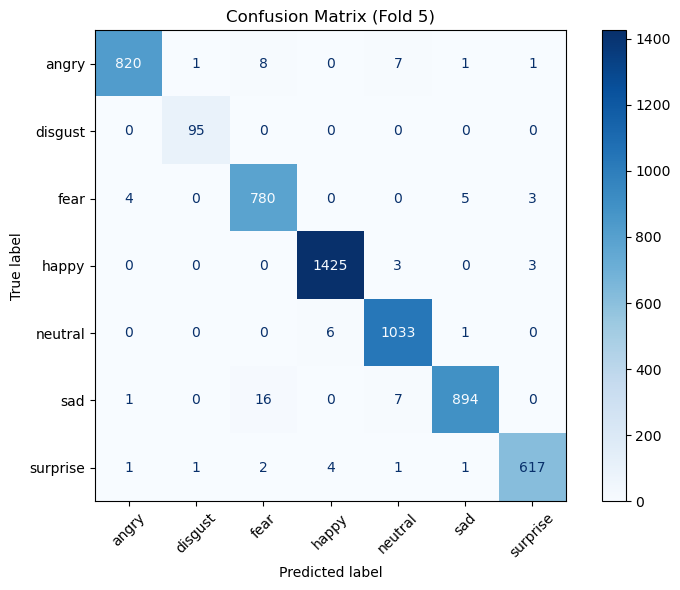

              precision    recall  f1-score   support

       angry       0.99      0.98      0.99       838
     disgust       0.98      1.00      0.99        95
        fear       0.97      0.98      0.98       792
       happy       0.99      1.00      0.99      1431
     neutral       0.98      0.99      0.99      1040
         sad       0.99      0.97      0.98       918
    surprise       0.99      0.98      0.99       627

    accuracy                           0.99      5741
   macro avg       0.99      0.99      0.99      5741
weighted avg       0.99      0.99      0.99      5741



In [21]:
# -------------------------
# ✅ 混淆矩阵 & 分类报告
# -------------------------
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, lbls in tqdm(val_loader, desc=f"[Fold {fold}] Confusion Matrix Eval"):
        imgs = imgs.to(device)
        outputs = model(pixel_values=imgs).logits
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(lbls.cpu().numpy())

# 画 confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title(f"Confusion Matrix (Fold {fold})")
plt.tight_layout()
plt.show()

# 打印分类报告（precision, recall, f1）
print(classification_report(all_labels, all_preds, target_names=label_names))


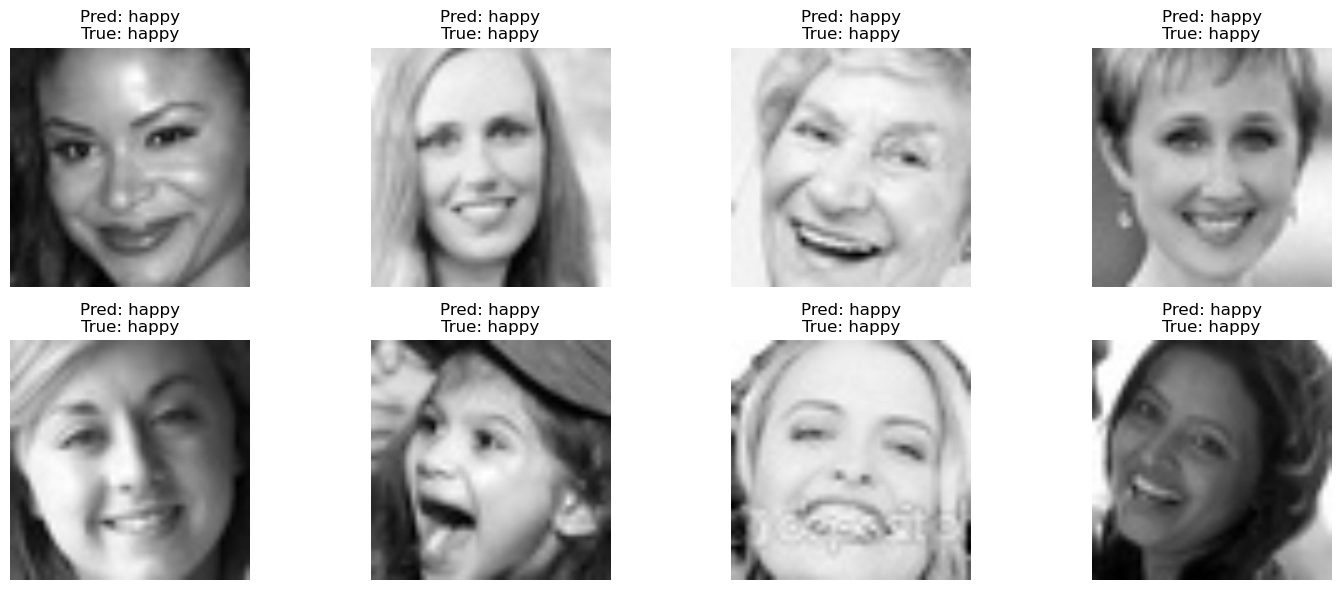

In [22]:
# -------------------------
# ✅ 可视化前8张预测图像
# -------------------------
import numpy as np

# 获取 val_loader 中第一 batch 图像和标签
imgs_vis, lbls_vis = next(iter(val_loader))
imgs_vis = imgs_vis.to(device)
lbls_vis = lbls_vis.to(device)

model.eval()
with torch.no_grad():
    outputs = model(pixel_values=imgs_vis).logits
    preds = outputs.argmax(dim=1)

# 显示前8张图片及其预测结果
plt.figure(figsize=(15, 6))
for i in range(8):
    img = imgs_vis[i].cpu().permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min())  # 归一化
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Pred: {label_names[preds[i].item()]}\nTrue: {label_names[lbls_vis[i].item()]}")
plt.tight_layout()
plt.show()
